In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from sklearn.utils import shuffle

In [ ]:
class MLP:
  def __init__(self, learning_rate=0.01, batch_size=32, hidden_node=10):
    self.lr = learning_rate
    self.batch_size = batch_size
    self.node = hidden_node
    self.losses = []  # 손실(훈련세트)
    self.val_losses = []  # 손실(검증세트)
    self.accuracy = []  # 정확도(훈련세트)
    self.val_accuracy = []  # 정확도(검증세트)

    self.w1 = None  # 은닉층 가중치
    self.b1 = None  # 은닉층 편향값
    self.w2 = None  # 출력층 가중치
    self.b2 = None  # 출력층 편향값

  def init_weights(self, m, n):  # 가중치 초기화 함수
    k = self.node
    self.w1 = np.random.normal(0, 1, (m, k))  # 가우시안 분포
    self.b1 = np.zeros(k)
    self.w2 = np.random.normal(0, 1, (k, n))  # 가우시안 분포
    self.b2 = np.zeros(n)

  def sigmoid(self, z1):  # sigmoid 함수
    z1 = np.clip(z1, -100, None)
    a1 = 1/(1+np.exp(-z1))
    return a1

  def softmax(self, z2):  # softmax 함수
    z2 = np.clip(z2, -100, None)
    exp_z2 = np.exp(z2)
    a2 = exp_z2/np.sum(exp_z2, axis=1).reshape(-1, 1)
    return a2

  def forward1(self, x):  # 입력층 -> 은닉층 순전파
    z1 = np.dot(x, self.w1)+self.b1
    return z1

  def forward2(self, a1):  # 은닉층 -> 출력층 순전파
    z2 = np.dot(a1, self.w2)+self.b2
    return z2

  def loss(self, x, y):  # 손실 계산
    z1 = self.forward1(x)
    a1 = self.sigmoid(z1)
    z2 = self.forward2(a1)
    a2 = self.softmax(z2)

    a2 = np.clip(a2, 1e-10, 1-1e-10)
    return -np.sum(y*np.log(a2))  # 크로스 엔트로피

  def backpropagation(self, x, y):  # 역전파
    z1 = self.forward1(x)
    a1 = self.sigmoid(z1)
    z2 = self.forward2(a1)
    a2 = self.softmax(z2)

    w2_grad = np.dot(a1.T, -(y-a2))  # 은닉층 가중치의 기울기
    b2_grad = np.sum(-(y-a2))  # 은닉층 편향값의 기울기

    # 은닉층 오차
    hidden_err = np.dot(-(y-a2), self.w2.T)*a1*(1-a1)

    w1_grad = np.dot(x.T, hidden_err)  # 입력층 가중치의 기울기
    b1_grad = np.sum(hidden_err, axis=0)  # 입력층 편향값의 기울기

    return w1_grad, b1_grad, w2_grad, b2_grad

  def minibatch(self, x, y): # 미니배치 경사하강법(SGD)
    iter = int(np.ceil(len(x)/self.batch_size))

    x, y = shuffle(x, y)

    for i in range(iter):
      start = self.batch_size*i
      end = self.batch_size*(i+1)
      yield x[start:end], y[start:end]

  def fit(self, x_data, y_data, epochs=40, x_val=None, y_val=None):
    self.init_weights(x_data.shape[1], y_data.shape[1])  # 가중치 초기화
    for epoch in range(epochs):
      l = 0  # 손실 누적 변수
      for x, y in self.minibatch(x_data, y_data):

        l += self.loss(x, y)  # 손실 누적
        w1_grad, b1_grad, w2_grad, b2_grad = self.backpropagation(x, y)

        # 은닉층 가중치와 편향값 업데이트
        self.w2 -= self.lr*(w2_grad)/len(x)
        self.b2 -= self.lr*(b2_grad)/len(x)

        # 입력층 가중치와 편향값 업데이트
        self.w1 -= self.lr*(w1_grad)/len(x)
        self.b1 -= self.lr*(b1_grad)/len(x)

      # 검증 손실 계산
      val_loss = self.val_loss(x_val, y_val)

      self.losses.append(l/len(y_data))
      self.val_losses.append(val_loss)
      self.accuracy.append(self.score(x_data, y_data))
      self.val_accuracy.append(self.score(x_val, y_val))

      print(f'Epoch [{epoch+1}/{epochs}] Train Loss : {l/len(y_data):.4f} accuracy : {self.score(x_data,y_data)*100:.2f}')

  def predict(self, x_data):
    z1 = self.forward1(x_data)
    a1 = self.sigmoid(z1)
    z2 = self.forward2(a1)
    return np.argmax(z2, axis=1)

  def score(self, x_data, y_data):
    return np.mean(self.predict(x_data) == np.argmax(y_data, axis=1))

  def val_loss(self, x_val, y_val):  # 검증 손실 계산
    val_loss = self.loss(x_val, y_val)
    return val_loss/len(y_val)


In [ ]:
# MNIST 데이터셋
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# 검증 세트 생성
validation_ratio = 0.2
total_samples = len(x_train)
validation_samples = int(total_samples * validation_ratio)

# 데이터 정규화(data normalization)
x_train, x_test = x_train / 255.0, x_test / 255.0

# 데이터를 1차원으로 평탄화
x_train = x_train.reshape(total_samples, -1)
x_test = x_test.reshape(len(x_test), -1)

# one-hot encoding
y_train = np.eye(10)[y_train]  # 정수 레이블을 one-hot으로 변환
y_test = np.eye(10)[y_test]

# 검증 데이터 분할
x_val, y_val = x_train[:validation_samples], y_train[:validation_samples]
x_train, y_train = x_train[validation_samples:], y_train[validation_samples:]


11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
model = MLP(learning_rate=0.1, batch_size=256, hidden_node=100)
model.fit(x_train, y_train, epochs=40, x_val=x_val, y_val=y_val)

Epoch [1/40] Train Loss : 2.9526 | accuracy : 55.06
Epoch [2/40] Train Loss : 1.4110 | accuracy : 67.65
Epoch [3/40] Train Loss : 1.0606 | accuracy : 73.40
Epoch [4/40] Train Loss : 0.8927 | accuracy : 76.50
Epoch [5/40] Train Loss : 0.7904 | accuracy : 78.60
Epoch [6/40] Train Loss : 0.7203 | accuracy : 80.03
Epoch [7/40] Train Loss : 0.6681 | accuracy : 81.26
Epoch [8/40] Train Loss : 0.6271 | accuracy : 82.33
Epoch [9/40] Train Loss : 0.5940 | accuracy : 83.09
Epoch [10/40] Train Loss : 0.5662 | accuracy : 83.78
Epoch [11/40] Train Loss : 0.5427 | accuracy : 84.44
Epoch [12/40] Train Loss : 0.5218 | accuracy : 84.98
Epoch [13/40] Train Loss : 0.5038 | accuracy : 85.45
Epoch [14/40] Train Loss : 0.4877 | accuracy : 85.87
Epoch [15/40] Train Loss : 0.4736 | accuracy : 86.31
Epoch [16/40] Train Loss : 0.4605 | accuracy : 86.61
Epoch [17/40] Train Loss : 0.4488 | accuracy : 86.86
Epoch [18/40] Train Loss : 0.4379 | accuracy : 87.14
Epoch [19/40] Train Loss : 0.4281 | accuracy : 87.42
Ep

In [ ]:
model.score(x_test,y_test)

0.9023

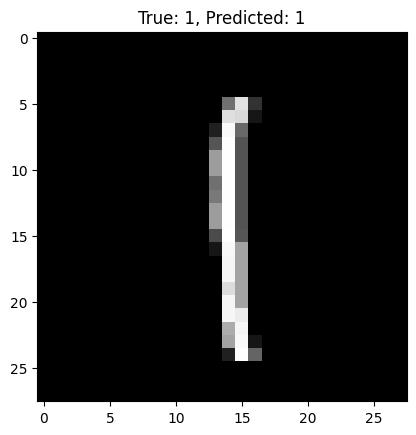

In [ ]:
# 테스트 이미지 선택
index = 203
test_image = x_test[index]
true_label = np.argmax(y_test[index])

# 선택한 이미지를 모델에 입력하여 예측
predicted_label = model.predict(test_image.reshape(1, -1))[0]

# 이미지와 예측 결과 출력
plt.imshow(test_image.reshape(28, 28), cmap='gray')
plt.title(f"True: {true_label}, Predicted: {predicted_label}")
plt.show()

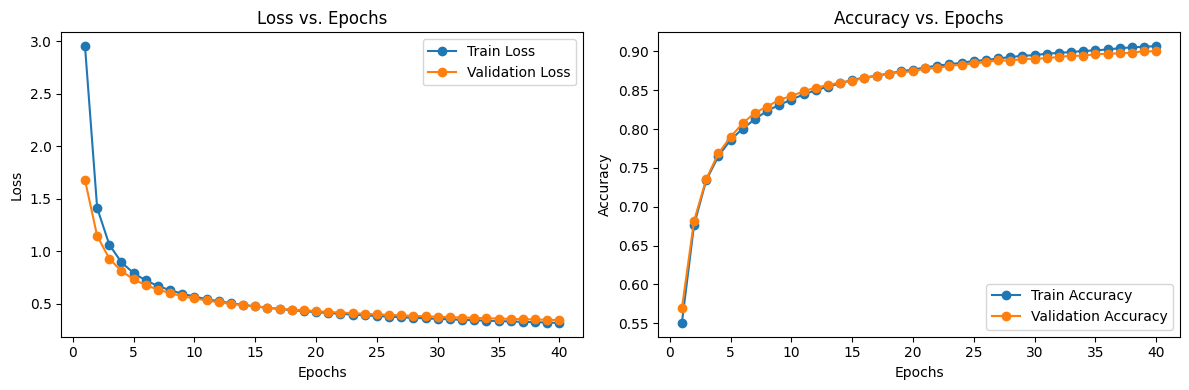

Test Accuracy: 90.23%


In [ ]:
import matplotlib.pyplot as plt

# 에폭 수
epochs = len(model.losses)

# 훈련 손실과 검증 손실 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), model.losses, label='Train Loss', marker='o')
plt.plot(range(1, epochs + 1), model.val_losses, label='Validation Loss', marker='o')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 훈련 정확도와 검증 정확도 시각화
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), model.accuracy, label='Train Accuracy', marker='o')
plt.plot(range(1, epochs + 1), model.val_accuracy, label='Validation Accuracy', marker='o')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# 테스트 데이터 정확도 출력
test_accuracy = model.score(x_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


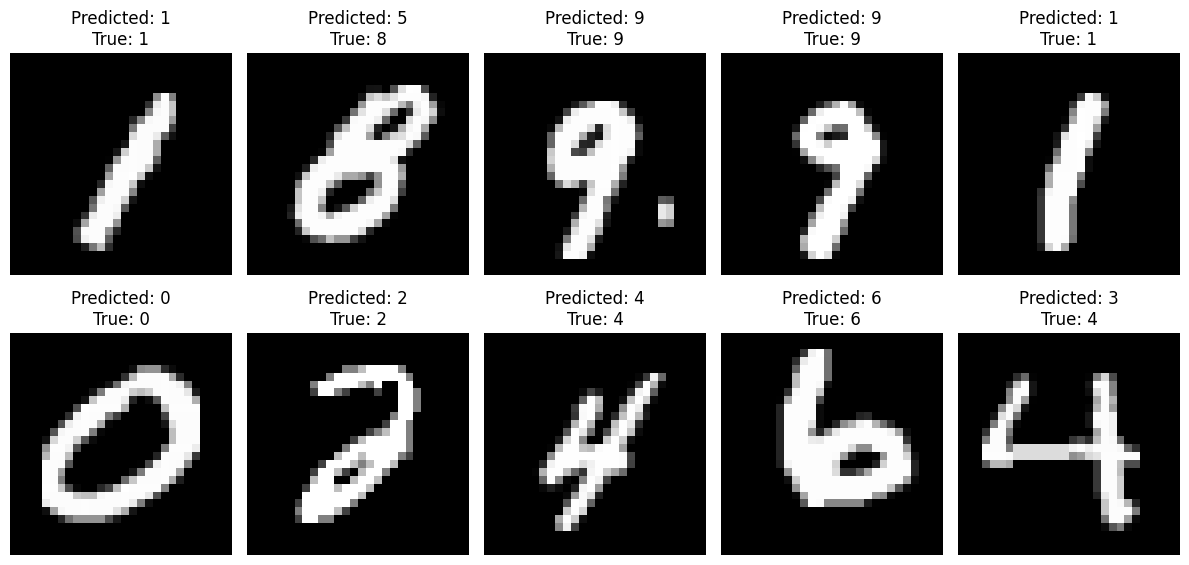

In [ ]:
import random

# 테스트 데이터에서 무작위 샘플 선택
sample_indices = random.sample(range(len(x_test)), 10)

# 선택한 샘플의 이미지, 예측 클래스 및 실제 클래스 시각화
plt.figure(figsize=(12, 6))
for i, index in enumerate(sample_indices):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_test[index].reshape(28, 28), cmap='gray')
    plt.title(f'Predicted: {model.predict(x_test[index].reshape(1, -1))[0]}\nTrue: {np.argmax(y_test[index])}')
    plt.axis('off')

plt.tight_layout()
plt.show()


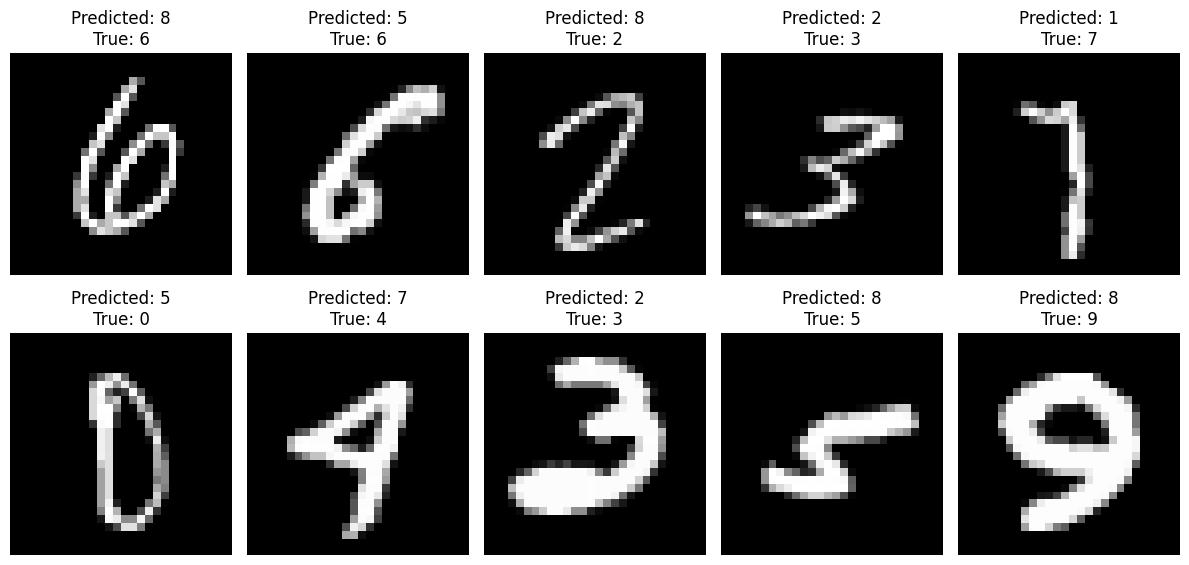

In [ ]:
# 오분류된 샘플 찾기
misclassified_indices = np.where(model.predict(x_test) != np.argmax(y_test, axis=1))[0]

# 무작위로 오분류된 샘플 선택
num_samples_to_visualize = min(10, len(misclassified_indices))
random_misclassified_indices = random.sample(list(misclassified_indices), num_samples_to_visualize)

# 오분류된 샘플 시각화
plt.figure(figsize=(12, 6))
for i, index in enumerate(random_misclassified_indices):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_test[index].reshape(28, 28), cmap='gray')
    predicted_class = model.predict(x_test[index].reshape(1, -1))[0]
    actual_class = np.argmax(y_test[index])
    plt.title(f'Predicted: {predicted_class}\nTrue: {actual_class}')
    plt.axis('off')

plt.tight_layout()
plt.show()
